<a href="https://colab.research.google.com/github/AndryADSM/Asset-Analyzer/blob/main/asset_analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Asset Analyzer Module
My Website: https://aadsm2355.wixsite.com/andryadsm

# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Download data

In [2]:
def download_data(
        tickers:     list[str],
        start:       str | None,
        end:         str | None,
        interval:    str  = '1d',
        *,
        actions:     bool = False,
        auto_adjust: bool = False
) -> pd.DataFrame:
    """
        Downloads price and volume data for each ticker from Yahoo Finance.
        #### return pd.DataFrame

        Params
        ---
        - tickers: list
            List of tickers to download.
        - start: str
            The start date formatted as 'YYYY-MM-DD', inclusive.
            If None, defaults to the maximum available time.
        - end: str
            The end date formatted as 'YYYY-MM-DD', exclusive.
            If None, defaults to the
        - interval: str='1d'
            Valid intervals:
                '1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo' or '3mo'.
            intraday data cannot extend last 60 days,
            except '60m' or '1h', up to last 730 days (1.5 years)
            and '1m', up to last 7 days (1 week)
        - actions: bool=False
            Download dividend & stock splits data.
        - auto_adjust: bool=False
            Adjusts all OHLC automatically.

        Example use
        ---
        `tickers = ['SPY', 'AAPL', 'TSLA', 'KO']`
        `data = aa.download_data(tickers, '2023-01-01', '2024-01-01', '1d')`
    """

    data = yf.download(tickers,
                       start=start,
                       end=end,
                       group_by='ticker',
                       interval=interval,
                       actions=actions,
                       auto_adjust=auto_adjust)

    if len(tickers) == 1:
        data.columns = pd.MultiIndex.from_product([tickers, data.columns],
                                                  names=['Ticker', 'Price'])
    return data[tickers]

tickers = ['SPY', 'AAPL', 'TSLA', 'KO']
data = download_data(tickers, '2023-01-01', '2024-01-01', '1d')
data

[*********************100%%**********************]  4 of 4 completed


Ticker             SPY                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2023-01-03  384.369995  386.429993  377.829987  380.820007  373.956818   
2023-01-04  383.179993  385.880005  380.000000  383.760010  376.843842   
2023-01-05  381.720001  381.839996  378.760010  379.380005  372.542755   
2023-01-06  382.609985  389.250000  379.410004  388.079987  381.085938   
2023-01-09  390.369995  393.700012  387.670013  387.859985  380.869934   
...                ...         ...         ...         ...         ...   
2023-12-22  473.859985  475.380005  471.700012  473.649994  472.182892   
2023-12-26  474.070007  476.579987  473.989990  475.649994  474.176697   
2023-12-27  475.440002  476.660004  474.890015  476.510010  475.034058   
2023-12-28  476.880005  477.549988  476.260010  476.690002  475.213501   
2023-12-29  476.489990  477.029999  473.299988  475.309998  473.837769   

Ticker                       AAPL                                      ...  \
Price          Volume        Open        High         Low       Close  ...   
Date                                                                   ...   
2023-01-03   74850700  130.279999  130.899994  124.169998  125.070000  ...   
2023-01-04   85934100  126.889999  128.660004  125.080002  126.360001  ...   
2023-01-05   76970500  127.129997  127.769997  124.760002  125.019997  ...   
2023-01-06  104189600  126.010002  130.289993  124.889999  129.619995  ...   
2023-01-09   73978100  130.470001  133.410004  129.889999  130.149994  ...   
...               ...         ...         ...         ...         ...  ...   
2023-12-22   67126600  195.179993  195.410004  192.970001  193.600006  ...   
2023-12-26   55387000  193.610001  193.889999  192.830002  193.050003  ...   
2023-12-27   68000300  192.490005  193.500000  191.089996  193.149994  ...   
2023-12-28   77158100  194.139999  194.660004  193.169998  193.580002  ...   
2023-12-29  122234100  193.899994  194.399994  191.729996  192.529999  ...   

Ticker            TSLA                                            KO  \
Price              Low       Close   Adj Close     Volume       Open   
Date                                                                   
2023-01-03  104.639999  108.099998  108.099998  231402800  63.560001   
2023-01-04  107.519997  113.639999  113.639999  180389000  63.150002   
2023-01-05  107.160004  110.339996  110.339996  157986300  62.599998   
2023-01-06  101.809998  113.059998  113.059998  220911100  62.910000   
2023-01-09  117.110001  119.769997  119.769997  190284000  63.299999   
...                ...         ...         ...        ...        ...   
2023-12-22  251.369995  252.539993  252.539993   93249800  58.119999   
2023-12-26  252.910004  256.609985  256.609985   86892400  58.060001   
2023-12-27  257.519989  261.440002  261.440002  106494400  58.639999   
2023-12-28  252.710007  253.179993  253.179993  113619900  58.650002   
2023-12-29  247.429993  248.479996  248.479996  100615300  58.740002   

Ticker                                                            
Price            High        Low      Close  Adj Close    Volume  
Date                                                              
2023-01-03  63.560001  62.180000  62.950001  60.540474  12180500  
2023-01-04  63.330002  62.509998  62.919998  60.511616  13387900  
2023-01-05  62.799999  62.080002  62.200001  59.819176   9814700  
2023-01-06  63.669998  62.580002  63.400002  60.973248   9990000  
2023-01-09  63.720001  62.580002  62.610001  60.213482   9442600  
...               ...        ...        ...        ...       ...  
2023-12-22  58.459999  58.020000  58.320000  57.857216   9028500  
2023-12-26  58.709999  58.060001  58.560001  58.095314   6422500  
2023-12-27  58.770000  58.400002  58.709999  58.244122   8560100  
2023-12-28  58.869999  58.529999  58.750000  58.283806   

# Get DataFrames

In [3]:
def pct_returns(
        data:      pd.DataFrame,
        values:    dict | None = None,
        *,
        round_val: int  = 6,
        as_pct:    bool = True
) -> pd.DataFrame:
    """
        Gets percentage return for the specified time frames.
        #### return pd.DataFrame

        Params
        ---
        - data: pd.DataFrame
            Takes price data with no modifications.
        - values: dict=None
            Takes dictionary in the form {str: (str, str, int)}
            notation {'Name_of_return': ('After_price', 'Before_price', shift_of_before_price)}
            if None, defaults to {'Daily': ('Close', 'Close', 1)}
        - round_val: int=6
            Number of decimals to be rounded to.
        - as_pct: bool=True
            If True, values are expressed as percentages (e.g. 1.23 (%)),
            if False, as decimals (e.g. 0.0123).

        Example use
        ---
        `data_ret = aa.pct_returns(data, values={'O_to_C': ('Close', 'Open' , 0), 'HL_diff': ('High' , 'Low'  , 0)}, round_val=2)`
    """

    if values is None:
        values = {'Daily': ('Close', 'Close', 1)}

    data_ret = pd.DataFrame(index=data.index,
                            columns=pd.MultiIndex.from_product([[], []],
                                                               names=['Ticker', 'TimeFrame']))

    for tk in data.columns.get_level_values(0).unique():
        # General formula
        for key, val in values.items():
            after, before, shift = val
            data_ret[tk, f'{key}'] = (data[tk, after] - data[tk, before].shift(shift)) \
                                     / data[tk, before].shift(shift) * 100

    data_ret = data_ret.round(round_val)

    # Turn percentage into decimal
    if as_pct == False:
        data_ret /= 100

    return data_ret

data_ret = pct_returns(data,
                       values={'Daily':    ('Close', 'Close', 1),
                               'Intraday': ('Close', 'Open' , 0),
                               'HL_diff':  ('High' , 'Low'  , 0)})
data_ret.head(10)

Ticker           SPY                          AAPL                      \
TimeFrame      Daily  Intraday   HL_diff     Daily  Intraday   HL_diff   
Date                                                                     
2023-01-03       NaN -0.923586  2.276158       NaN -3.999078  5.419985   
2023-01-04  0.772019  0.151369  1.547370  1.031423 -0.417684  2.862170   
2023-01-05 -1.141340 -0.613014  0.813176 -1.060465 -1.659719  2.412628   
2023-01-06  2.293210  1.429655  2.593499  3.679410  2.864846  4.323800   
2023-01-09 -0.056690 -0.642982  1.555446  0.408887 -0.245273  2.709989   
2023-01-10  0.701284  0.859906  1.133923  0.445641  0.360818  2.450827   
2023-01-11  1.264786  0.838788  1.078236  2.111229  1.706671  2.337872   
2023-01-12  0.364078  0.073103  1.546806 -0.059931 -0.351062  2.145460   
2023-01-13  0.387951  1.239776  1.464384  1.011911  2.067709  2.476070   
2023-01-17 -0.183190 -0.178183  0.798371  0.875637  0.823259  2.355915   

Ticker          TSLA                             KO                      
TimeFrame      Daily  Intraday    HL_diff     Daily  Intraday   HL_diff  
Date                                                                     
2023-01-03       NaN -8.753273  13.532114       NaN -0.959724  2.219365  
2023-01-04  5.124885  4.151772   6.575521 -0.047661 -0.364218  1.311796  
2023-01-05 -2.903910 -0.153837   4.283311 -1.144306 -0.638974  1.159790  
2023-01-06  2.465109  9.766988  12.356352  1.929262  0.778893  1.741765  
2023-01-09  5.934901  0.680899   5.473483 -1.246058 -1.090045  1.821667  
2023-01-10 -0.768137 -1.833651   6.822141 -0.766650 -0.750795  1.308142  
2023-01-11  3.676906  0.925551   4.514144 -0.193148 -0.593143  1.872662  
2023-01-12  0.275926  0.815927   6.094015 -1.290113 -1.449044  1.984581  
2023-01-13 -0.938812  5.019304   6.081314  0.359420  1.202635  1.435879  
2023-01-17  7.426474  4.606212   5.343145  0.406967 -0.080997  1.332033

In [4]:
def pct_returns_daily(
        data:      pd.DataFrame,
        *,
        round_val: int  = 6,
        as_pct:    bool = True
) -> pd.DataFrame:
    """
        Gets percentage return for different time frames for daily price data.
        #### return pd.DataFrame

        Params
        ---
        - data: pd.DataFrame
            Takes price data of interval '1d' with no modifications.
        - round_val: int=6
            Number of decimals to be rounded to.
        - as_pct: bool=True
            If True, values are expressed as percentages (e.g. 1.23 (%)),
            if False, as decimals (e.g. 0.0123).

        Example use
        ---
        `data_ret_d = aa.pct_returns_daily(data)`

    """

    values = {'Intraday':  ('Close', 'Open' , 0 ),
              'Overnight': ('Open' , 'Close', 1 ),
              'Daily':     ('Close', 'Close', 1 ),
              '1week':     ('Close', 'Close', 5 ),
              '2week':     ('Close', 'Close', 10),
              '3week':     ('Close', 'Close', 15),
              '4week':     ('Close', 'Close', 20)}

    data_ret = pct_returns(data=data,
                           values=values,
                           round_val=round_val,
                           as_pct=as_pct)
    return data_ret

data_ret_d = pct_returns_daily(data)
data_ret_d.head(10)

Ticker           SPY                                                  \
TimeFrame   Intraday Overnight     Daily     1week 2week 3week 4week   
Date                                                                   
2023-01-03 -0.923586       NaN       NaN       NaN   NaN   NaN   NaN   
2023-01-04  0.151369  0.619711  0.772019       NaN   NaN   NaN   NaN   
2023-01-05 -0.613014 -0.531584 -1.141340       NaN   NaN   NaN   NaN   
2023-01-06  1.429655  0.851384  2.293210       NaN   NaN   NaN   NaN   
2023-01-09 -0.642982  0.590087 -0.056690       NaN   NaN   NaN   NaN   
2023-01-10  0.859906 -0.157269  0.701284  2.562885   NaN   NaN   NaN   
2023-01-11  0.838788  0.422455  1.264786  3.064410   NaN   NaN   NaN   
2023-01-12  0.073103  0.290763  0.364078  4.633873   NaN   NaN   NaN   
2023-01-13  1.239776 -0.841394  0.387951  2.685017   NaN   NaN   NaN   
2023-01-17 -0.178183 -0.005016 -0.183190  2.555047   NaN   NaN   NaN   

Ticker          AAPL                      ...  TSLA                    KO  \
TimeFrame   Intraday Overnight     Daily  ... 2week 3week 4week  Intraday   
Date                                      ...                               
2023-01-03 -3.999078       NaN       NaN  ...   NaN   NaN   NaN -0.959724   
2023-01-04 -0.417684  1.455185  1.031423  ...   NaN   NaN   NaN -0.364218   
2023-01-05 -1.659719  0.609367 -1.060465  ...   NaN   NaN   NaN -0.638974   
2023-01-06  2.864846  0.791878  3.679410  ...   NaN   NaN   NaN  0.778893   
2023-01-09 -0.245273  0.655768  0.408887  ...   NaN   NaN   NaN -1.090045   
2023-01-10  0.360818  0.084518  0.445641  ...   NaN   NaN   NaN -0.750795   
2023-01-11  1.706671  0.397770  2.111229  ...   NaN   NaN   NaN -0.593143   
2023-01-12 -0.351062  0.292156 -0.059931  ...   NaN   NaN   NaN -1.449044   
2023-01-13  2.067709 -1.034409  1.011911  ...   NaN   NaN   NaN  1.202635   
2023-01-17  0.823259  0.051950  0.875637  ...   NaN   NaN   NaN -0.080997   

Ticker                                                      
TimeFrame  Overnight     Daily     1week 2week 3week 4week  
Date                                                        
2023-01-03       NaN       NaN       NaN   NaN   NaN   NaN  
2023-01-04  0.317714 -0.047661       NaN   NaN   NaN   NaN  
2023-01-05 -0.508582 -1.144306       NaN   NaN   NaN   NaN  
2023-01-06  1.141478  1.929262       NaN   NaN   NaN   NaN  
2023-01-09 -0.157732 -1.246058       NaN   NaN   NaN   NaN  
2023-01-10 -0.015975 -0.766650 -1.302621   NaN   NaN   NaN  
2023-01-11  0.402382 -0.193148 -1.446281   NaN   NaN   NaN  
2023-01-12  0.161268 -1.290113 -1.591643   NaN   NaN   NaN  
2023-01-13 -0.833194  0.359420 -3.107257   NaN   NaN   NaN  
2023-01-17  0.488359  0.406967 -1.485386   NaN   NaN   NaN  

[10 rows x 28 columns]

In [5]:
def insights(
        data_ret:   pd.DataFrame,
        *,
        volatility: bool = True,
        mean:       bool = True,
        mean_abs:   bool = True,
        order_by:   str  = 'ins'
) -> pd.DataFrame:
    """
        Gets insights like volatility, mean and mean of absolute values
        about the returns data.
        #### return pd.DataFrame

        Params
        ---
        - data_ret: pd.DataFrame
            Takes returns data,
            can get it with the pct_returns() function.
        - volatility: bool=True
            If to include the volatility measure.
        - mean: bool=True
            If to include the mean measure.
        - mean_abs: bool=True
            If to include the mean of the absolute values measure.
        - order_by: str='ins'
            If 'ins', order the index by insights,
            if 'ret', order by return.

        Example use
        ---
        `data_ins = aa.insights(data_ret, order_by='ins')`
    """

    data_ins = pd.DataFrame(columns=pd.MultiIndex.from_product([[], []],
                                                               names=['Insight', 'Return']))

    tks = data_ret.columns.get_level_values(0).unique()
    ret = data_ret.columns.get_level_values(1).unique()

    for col in ret:
        if volatility:
            data_ins['Volatility', f'{col}'] = {tk: (data_ret[tk, col].std()) for tk in tks}
        if mean:
            data_ins['Mean', f'{col}'] = {tk: data_ret[tk, col].mean() for tk in tks}
        if mean_abs:
            data_ins['Mean_abs', f'{col}'] = {tk: data_ret[tk, col].abs().mean() for tk in tks}

    data_ins = data_ins.T
    data_ins = data_ins.loc[data_ins.index.get_level_values(0).unique()]

    if order_by == 'ret':
        data_ins = data_ins.swaplevel('Return', 'Insight').loc[ret]
        return data_ins
    return data_ins

data_ins = insights(data_ret)
data_ins

SPY      AAPL      TSLA        KO
Insight    Return                                          
Volatility Daily     0.831854  1.256559  3.316561  0.838404
           Intraday  0.710795  1.097405  2.822076  0.760887
           HL_diff   0.490868  0.784681  1.810100  0.564129
Mean       Daily     0.092496  0.181245  0.389272 -0.022983
           Intraday  0.072728  0.189365  0.274616 -0.066516
           HL_diff   1.055279  1.722160  4.355483  1.239302
Mean_abs   Daily     0.655174  0.973397  2.526449  0.612933
           Intraday  0.553649  0.861888  2.191155  0.557293
           HL_diff   1.055279  1.722160  4.355483  1.239302

In [6]:
def top_results(
        data_ins:  pd.DataFrame,
        *,
        top:       int = 3,
        bot:       int = 3,
        round_val: int = 6
) -> None:
    """
        Displays the top and bottom results of the insights data.
        #### return None

        Params
        - data_ins: pd.DataFrame
            Takes insights data,
            can get it with the insights() function.
        - top: int=3
            Top n to display.
        - bot: int=3
            Bottom n to display.
        - round_val: int=6
            Number of decimals to be rounded to.
        ---

        Example use
        ---
        `aa.top_results(data_ins, top=2, bot=1, round_val=3)`
    """

    for i in data_ins.index:
        display(pd.DataFrame(
            [data_ins.loc[i].nlargest(top).round(round_val),
             data_ins.loc[i].nsmallest(bot).round(round_val).sort_values(ascending=False)],
            index=[f'Top {i[0]}, {i[1]}', f'Bottom {i[0]}, {i[1]}']
        ))

top_results(data_ins, top=2, bot=1, round_val=3)

,TSLA,AAPL,SPY
"Top Volatility, Daily",3.317,1.257,NaN
"Bottom Volatility, Daily",NaN,NaN,0.832


,TSLA,AAPL,SPY
"Top Volatility, Intraday",2.822,1.097,NaN
"Bottom Volatility, Intraday",NaN,NaN,0.711


,TSLA,AAPL,SPY
"Top Volatility, HL_diff",1.81,0.785,NaN
"Bottom Volatility, HL_diff",NaN,NaN,0.491


,TSLA,AAPL,KO
"Top Mean, Daily",0.389,0.181,NaN
"Bottom Mean, Daily",NaN,NaN,-0.023


,TSLA,AAPL,KO
"Top Mean, Intraday",0.275,0.189,NaN
"Bottom Mean, Intraday",NaN,NaN,-0.067


,TSLA,AAPL,SPY
"Top Mean, HL_diff",4.355,1.722,NaN
"Bottom Mean, HL_diff",NaN,NaN,1.055


,TSLA,AAPL,KO
"Top Mean_abs, Daily",2.526,0.973,NaN
"Bottom Mean_abs, Daily",NaN,NaN,0.613


,TSLA,AAPL,SPY
"Top Mean_abs, Intraday",2.191,0.862,NaN
"Bottom Mean_abs, Intraday",NaN,NaN,0.554


,TSLA,AAPL,SPY
"Top Mean_abs, HL_diff",4.355,1.722,NaN
"Bottom Mean_abs, HL_diff",NaN,NaN,1.055


In [7]:
def normalize_values(
        data:   pd.DataFrame,
        *,
        volume: bool = True
) -> pd.DataFrame:
    """
        Gets normalized price and volume data.
        #### return pd.DataFrame

        Params
        ---
        - data: pd.DataFrame
            Takes price and volume data with no modifications.
        - volume: bool=True
            If to include normalized volume data

        Example use
        ---
        `data_norm = aa.normalize_values(data)`
    """

    data_norm = pd.DataFrame(columns=pd.MultiIndex.from_product([[], []],
                                                                names=['Ticker', 'Price']))
    tks = data.columns.get_level_values(0).unique()
    prices = [price for price in data.columns.get_level_values(1).unique() \
              if price in ['Open', 'High', 'Low', 'Close', 'Adj Close']]

    # Calculate min and max price across all prices for each ticker
    min_price = {tk: data[tk][prices].min().min() for tk in tks}
    max_price = {tk: data[tk][prices].max().max() for tk in tks}

    # Normalize between 0 and 1
    for tk in tks:
        for price in prices:
            data_norm[tk, f'{price}_norm']  = (data[tk, price]  - min_price[tk]) \
                                              / (max_price[tk] - min_price[tk])
        if volume and 'Volume' in data.columns.get_level_values(1).unique():
            vol = data[tk, 'Volume']
            data_norm[tk, 'Volume_norm'] = (vol - vol.min()) \
                                           / (vol.max() - vol.min())

    return data_norm

data_norm = normalize_values(data)
data_norm

Ticker           SPY                                                \
Price      Open_norm High_norm  Low_norm Close_norm Adj Close_norm   
Date                                                                 
2023-01-03  0.112633  0.132250  0.050351   0.078826       0.013466   
2023-01-04  0.101300  0.127013  0.071016   0.106824       0.040960   
2023-01-05  0.087396  0.088539  0.059208   0.065112       0.000000   
2023-01-06  0.095872  0.159106  0.065398   0.147963       0.081358   
2023-01-09  0.169772  0.201484  0.144059   0.145868       0.079301   
...              ...       ...       ...        ...            ...   
2023-12-22  0.964860  0.979335  0.944290   0.962860       0.948888   
2023-12-26  0.966860  0.990763  0.966098   0.981906       0.967876   
2023-12-27  0.979906  0.991525  0.974669   0.990096       0.976040   
2023-12-28  0.993620  1.000000  0.987715   0.991810       0.977749   
2023-12-29  0.989905  0.995048  0.959527   0.978668       0.964648   

Ticker                      AAPL                                 ...  \
Price      Volume_norm Open_norm High_norm  Low_norm Close_norm  ...   
Date                                                             ...   
2023-01-03    0.282814  0.083066  0.091264  0.002269   0.014170  ...   
2023-01-04    0.352296  0.038237  0.061643  0.014302   0.031229  ...   
2023-01-05    0.296103  0.041411  0.049874  0.010071   0.013509  ...   
2023-01-06    0.466739  0.026600  0.083198  0.011790   0.074338  ...   
2023-01-09    0.277344  0.085578  0.124456  0.077908   0.081347  ...   
...                ...       ...       ...       ...        ...  ...   
2023-12-22    0.234392  0.941287  0.944328  0.912062   0.920393  ...   
2023-12-26    0.160797  0.920525  0.924228  0.910211   0.913120  ...   
2023-12-27    0.239869  0.905715  0.919071  0.887201   0.914442  ...   
2023-12-28    0.297279  0.927534  0.934410  0.914707   0.920129  ...   
2023-12-29    0.579860  0.924360  0.930972  0.895665   0.906244  ...   

Ticker          TSLA                                              KO  \
Price       Low_norm Close_norm Adj Close_norm Volume_norm Open_norm   
Date                                                                   
2023-01-03  0.014331   0.031851       0.031851    0.688619  0.893601   
2023-01-04  0.028914   0.059905       0.059905    0.477351  0.863095   
2023-01-05  0.027091   0.043194       0.043194    0.384573  0.822173   
2023-01-06  0.000000   0.056968       0.056968    0.645169  0.845238   
2023-01-09  0.077476   0.090946       0.090946    0.518330  0.874256   
...              ...        ...            ...         ...       ...   
2023-12-22  0.757342   0.763267       0.763267    0.116475  0.488839   
2023-12-26  0.765141   0.783877       0.783877    0.090146  0.484375   
2023-12-27  0.788485   0.808335       0.808335    0.171326  0.527530   
2023-12-28  0.764128   0.766508       0.766508    0.200835  0.528274   
2023-12-29  0.737391   0.742708       0.742708    0.146978  0.534970   

Ticker                                                                
Price      High_norm  Low_norm Close_norm Adj Close_norm Volume_norm  
Date                                                                  
2023-01-03  0.893601  0.790923   0.848214       0.668934    0.122017  
2023-01-04  0.876488  0.815476   0.845982       0.666787    0.142022  
2023-01-05  0.837054  0.783482   0.792411       0.615266    0.082820  
2023-01-06  0.901786  0.820685   0.881697       0.701135    0.085724  
2023-01-09  0.905506  0.820685   0.822917       0.644604    0.076655  
...              ...       ...        ...            ...         ...  
2023-12-22  0.514137  0.481399   0.503720       0.469287    0.069794  
2023-12-26  0.532738  0.484375   0.521578       0.487003    0.026617  
2023-12-27  0.537203  0.509673   0.532738       0.498075    0.062033  
2023-12-28  0.544643  0.519345   0.535714       0.501027    0.059382  
2023-12-29  0.552827  0.526786   0.549107       0.514314    0.073325  

[250 r

# Modifier

In [8]:
def drop_columns(
        data: pd.DataFrame,
        cols: str | list[str],
        *,
        inplace: bool = False
) -> pd.DataFrame:
    """
        Drops all the columns specified out of the second level.
        Similar to using the pandas drop() method.
        #### return pd.DataFrame

        Params
        ---
        - data: pd.DataFrame
            Data where the columns are going to be dropped.
        - cols: str | list[str]
            Labels of columns to be dropped.
        - inplace: bool=False
            If False, return a copy,
            if True, do operation inplace (overwrite).

        Example use
        ---
        `data_drop = aa.drop_columns(data, 'Adj Close')`
    """

    # To be able to input a string
    if type(cols) == str:
        cols =[cols]

    # To overwrite
    if inplace:
        data.drop(columns=cols, inplace=True, level=1, errors='ignore')
    # Not to overwrite
    else:
        data = data.drop(columns=cols, level=1, errors='ignore')

    return data

data_drop = drop_columns(data, 'Adj Close')
data_drop

Ticker             SPY                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2023-01-03  384.369995  386.429993  377.829987  380.820007   74850700   
2023-01-04  383.179993  385.880005  380.000000  383.760010   85934100   
2023-01-05  381.720001  381.839996  378.760010  379.380005   76970500   
2023-01-06  382.609985  389.250000  379.410004  388.079987  104189600   
2023-01-09  390.369995  393.700012  387.670013  387.859985   73978100   
...                ...         ...         ...         ...        ...   
2023-12-22  473.859985  475.380005  471.700012  473.649994   67126600   
2023-12-26  474.070007  476.579987  473.989990  475.649994   55387000   
2023-12-27  475.440002  476.660004  474.890015  476.510010   68000300   
2023-12-28  476.880005  477.549988  476.260010  476.690002   77158100   
2023-12-29  476.489990  477.029999  473.299988  475.309998  122234100   

Ticker            AAPL                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2023-01-03  130.279999  130.899994  124.169998  125.070000  112117500   
2023-01-04  126.889999  128.660004  125.080002  126.360001   89113600   
2023-01-05  127.129997  127.769997  124.760002  125.019997   80962700   
2023-01-06  126.010002  130.289993  124.889999  129.619995   87754700   
2023-01-09  130.470001  133.410004  129.889999  130.149994   70790800   
...                ...         ...         ...         ...        ...   
2023-12-22  195.179993  195.410004  192.970001  193.600006   37122800   
2023-12-26  193.610001  193.889999  192.830002  193.050003   28919300   
2023-12-27  192.490005  193.500000  191.089996  193.149994   48087700   
2023-12-28  194.139999  194.660004  193.169998  193.580002   34049900   
2023-12-29  193.899994  194.399994  191.729996  192.529999   42628800   

Ticker            TSLA                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2023-01-03  118.470001  118.800003  104.639999  108.099998  231402800   
2023-01-04  109.110001  114.589996  107.519997  113.639999  180389000   
2023-01-05  110.510002  111.750000  107.160004  110.339996  157986300   
2023-01-06  103.000000  114.389999  101.809998  113.059998  220911100   
2023-01-09  118.959999  123.519997  117.110001  119.769997  190284000   
...                ...         ...         ...         ...        ...   
2023-12-22  256.760010  258.220001  251.369995  252.539993   93249800   
2023-12-26  254.490005  257.970001  252.910004  256.609985   86892400   
2023-12-27  258.350006  263.339996  257.519989  261.440002  106494400   
2023-12-28  263.660004  265.130005  252.710007  253.179993  113619900   
2023-12-29  255.100006  255.190002  247.429993  248.479996  100615300   

Ticker             KO                                             
Price            Open       High        Low      Close    Volume  
Date                                                              
2023-01-03  63.560001  63.560001  62.180000  62.950001  12180500  
2023-01-04  63.150002  63.330002  62.509998  62.919998  13387900  
2023-01-05  62.599998  62.799999  62.080002  62.200001   9814700  
2023-01-06  62.910000  63.669998  62.580002  63.400002   9990000  
2023-01-09  63.299999  63.720001  62.580002  62.610001   9442600  
...               ...        ...        ...        ...       ...  
2023-12-22  58.119999  58.459999  58.020000  58.320000   9028500  
2023-12-26  58.060001  58.709999  58.060001  58.560001   6422500  
2023-12-27  58.639999  58.770000  58.400002  58.709999   8560100  
2023-12-28  58.650002  58.869999  58.529999  58.750000   8400100  
2023-12-29  58.740002  58.980000  58.630001  58.930000   924

# Get date values

In [9]:
def from_datetime(
        data:   pd.DataFrame,
        get:    str,
        *,
        concat: bool = False,
        place:  str  = 'beg'
) -> pd.DataFrame:
    """
        Get a DataFrame with the datetime value gotten from the index.
        Can concatenate with the source DataFrame.
        #### return pd.DataFrame

        Params
        ---
        - data: pd.DataFrame
            Takes data with DatetimeIndex as index.
        - get: str
            The value to get from the datetime index.
            Valid inputs are:
                'minute', 'hour', 'weekday', 'day_name', 'day', 'month', 'month_name', 'quarter' or 'year'
        - concat: bool=False
            If to concatenate with the source data.
        - place: str='beg'
            Where the column is going to be placed when concatenated.
            If 'beg', at the beginning (left) of the DataFrame,
            if 'end', at the end (right) of it.

        Example use
        ---
        `data_date = aa.from_datetime(data, 'weekday', concat=True)`

    """

    # Check if the input for interval is valid
    inputs = ['minute', 'hour', 'weekday', 'day_name', 'day', 'month', 'month_name', 'quarter', 'year']
    if get not in inputs:
        raise ValueError(f'Invalid input, get=\'{get}\', valid inputs are: {inputs}')

    # Check if the column already exist and do nothing
    if concat and f'{get.capitalize()}' in data.columns.get_level_values(1).unique():
        raise Exception(f'Already a column named \'{get}\'.')

    df = pd.DataFrame(index=data.index)
    dt = data.index.to_frame().iloc[:,0].dt

    # Get the actual datetime
    if 'name' in get:
        dt = eval(f'dt.{get}()')
    else:
        dt = eval(f'dt.{get}')
    df[f'{get.capitalize()}'] = dt

    # If to concatenate with the data
    if concat:
        df.columns = pd.MultiIndex.from_arrays([['Datetime'], [f'{get.capitalize()}']])
        if place == 'end':
            return pd.concat([data, df], axis=1)
        return pd.concat([df, data], axis=1)
    return df

data_date = from_datetime(data, 'weekday', concat=True)
data_date

Datetime         SPY                                      \
            Weekday        Open        High         Low       Close   
Date                                                                  
2023-01-03        1  384.369995  386.429993  377.829987  380.820007   
2023-01-04        2  383.179993  385.880005  380.000000  383.760010   
2023-01-05        3  381.720001  381.839996  378.760010  379.380005   
2023-01-06        4  382.609985  389.250000  379.410004  388.079987   
2023-01-09        0  390.369995  393.700012  387.670013  387.859985   
...             ...         ...         ...         ...         ...   
2023-12-22        4  473.859985  475.380005  471.700012  473.649994   
2023-12-26        1  474.070007  476.579987  473.989990  475.649994   
2023-12-27        2  475.440002  476.660004  474.890015  476.510010   
2023-12-28        3  476.880005  477.549988  476.260010  476.690002   
2023-12-29        4  476.489990  477.029999  473.299988  475.309998   

                                         AAPL                          ...  \
             Adj Close     Volume        Open        High         Low  ...   
Date                                                                   ...   
2023-01-03  373.956818   74850700  130.279999  130.899994  124.169998  ...   
2023-01-04  376.843842   85934100  126.889999  128.660004  125.080002  ...   
2023-01-05  372.542755   76970500  127.129997  127.769997  124.760002  ...   
2023-01-06  381.085938  104189600  126.010002  130.289993  124.889999  ...   
2023-01-09  380.869934   73978100  130.470001  133.410004  129.889999  ...   
...                ...        ...         ...         ...         ...  ...   
2023-12-22  472.182892   67126600  195.179993  195.410004  192.970001  ...   
2023-12-26  474.176697   55387000  193.610001  193.889999  192.830002  ...   
2023-12-27  475.034058   68000300  192.490005  193.500000  191.089996  ...   
2023-12-28  475.213501   77158100  194.139999  194.660004  193.169998  ...   
2023-12-29  473.837769  122234100  193.899994  194.399994  191.729996  ...   

                  TSLA                                            KO  \
                   Low       Close   Adj Close     Volume       Open   
Date                                                                   
2023-01-03  104.639999  108.099998  108.099998  231402800  63.560001   
2023-01-04  107.519997  113.639999  113.639999  180389000  63.150002   
2023-01-05  107.160004  110.339996  110.339996  157986300  62.599998   
2023-01-06  101.809998  113.059998  113.059998  220911100  62.910000   
2023-01-09  117.110001  119.769997  119.769997  190284000  63.299999   
...                ...         ...         ...        ...        ...   
2023-12-22  251.369995  252.539993  252.539993   93249800  58.119999   
2023-12-26  252.910004  256.609985  256.609985   86892400  58.060001   
2023-12-27  257.519989  261.440002  261.440002  106494400  58.639999   
2023-12-28  252.710007  253.179993  253.179993  113619900  58.650002   
2023-12-29  247.429993  248.479996  248.479996  100615300  58.740002   

                                                                  
                 High        Low      Close  Adj Close    Volume  
Date                                                              
2023-01-03  63.560001  62.180000  62.950001  60.540474  12180500  
2023-01-04  63.330002  62.509998  62.919998  60.511616  13387900  
2023-01-05  62.799999  62.080002  62.200001  59.819176   9814700  
2023-01-06  63.669998  62.580002  63.400002  60.973248   9990000  
2023-01-09  63.720001  62.580002  62.610001  60.213482   9442600  
...               ...        ...        ...        ...       ...  
2023-12-22  58.459999  58.020000  58.320000  57.857216   9028500  
2023-12-26  58.709999  58.060001  58.560001  58.095314   6422500  
2023-12-27  58.770000  58.400002  58.709999  58.244122   8560100  
2023-12-28  58.869999  58.529999  58.750000  58.283806   8400100  
2023-12-29  58.980000  58.630001  58.930000

# Plots

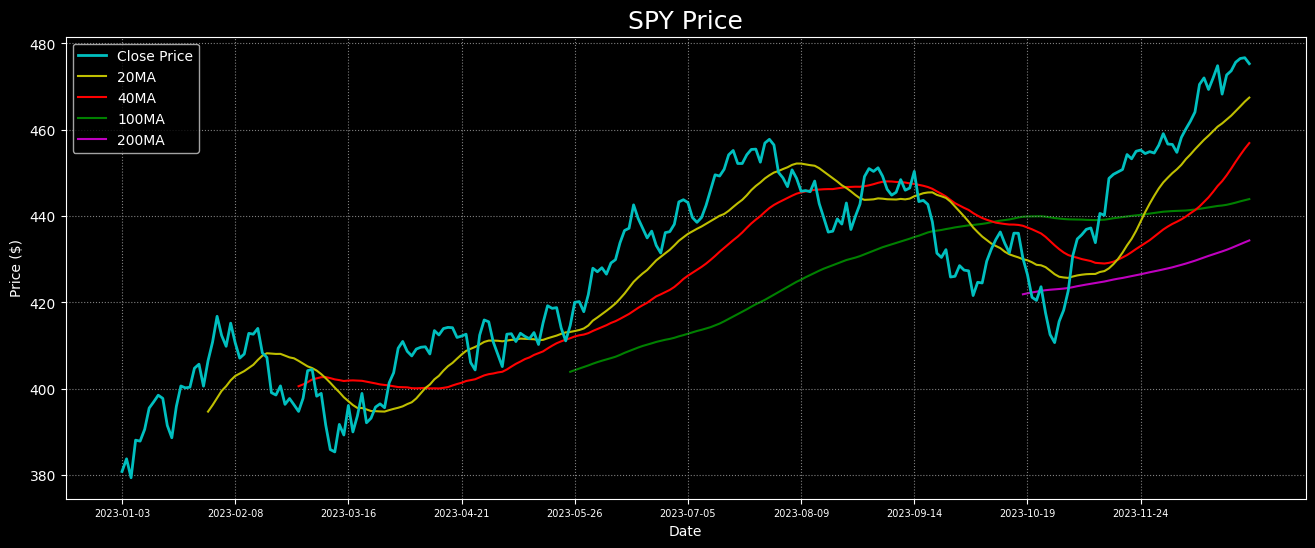

In [10]:
def plot_price(
        data:   pd.DataFrame,
        ticker: str,
        start:  str | None = None,
        end:    str | None = None,
        *,
        style:     str                 = 'dark_background',
        figsize:   tuple[float] | None = None,
        use_price: str                 = 'Close',
        color:     str                 = 'c',
        mas:       list[int] | bool    = True,
        mas_color: list[str] | None    = None,
        legendloc: str | None          = None
) -> None:
    """
        Plots the price and moving averages of a specific ticker.
        #### return None

        Params
        ---
        - data: pd.DataFrame
            Takes price data with no modifications.
        - ticker: str
            The ticker to plot.
        - start: str | None=None
            The start date formatted as 'YYYY-MM-DD' or 'YYYY-MM-DD hh:mm', inclusive.
        - end: str | None=None
            The end date formatted as 'YYYY-MM-DD' or 'YYYY-MM-DD hh:mm', inclusive.
        - style: str='dark_background'
            Style of the plot, check available styles with `plt.style.available`
        - figsize: tuple[int] | None=None
            Width and height of the plot,
            if None, defaults to (16, 6)
        - use_price: str='Close'
            The price column to be used for plotting the price.
        - color: str='cyan'
            Color of the price line.
        - mas: list[str] | None=None
            Length of price moving averages, as many as wished,
            if None, defaults to 20, 40, 100 and 200
        - mas_color: list[str] | None=None
            Color of each of the price moving averages in order,
            if None, defaults to a palette.
        - legendloc: str | None=None
            Location of the legend,
            if None, defaults to the best location.

        Example use
        ---
        `aa.plot_price(data, 'SPY', color='w', mas=[20, 50, 100, 150])`
    """

    # Prepare data to be plotted
    date_format = '%Y-%m-%d'
    if data.index.name == 'Datetime':
        date_format = '%Y-%m-%d %H:%M'
    data_to_plot = data.loc[start:end][ticker]
    data_to_plot.index = data_to_plot.index.strftime(date_format)
    data_ma = data[ticker]
    data_ma.index = data_ma.index.strftime(date_format)

    # Plot
    with plt.style.context(style):
        if figsize is None:
            figsize = (16, 6)

        plt.figure(figsize=figsize)
        plt.title(f'{ticker} Price', size=18)

        # Price
        plt.plot(data_to_plot[use_price],
                 color=color,
                 linewidth=2,
                 zorder=20,
                 label=f'{use_price} Price')

        # Price Moving Averages
        if mas is not False:
            if mas is True:
                mas = [20, 40, 100, 200]
            if mas_color is None:
                 mas_color = ['y', 'r', 'g', 'm']

            for m, c, z in zip(mas,
                               range(len(mas_color)+100),
                               range(len(mas)-1, -1, -1)):
                plt.plot(data_ma[use_price].rolling(m).mean().loc[start:end],
                         color=mas_color[c % len(mas_color)],
                         zorder=z,
                         label=f'{m}MA')

        plt.grid(which='major', color='grey', linestyle=':')
        plt.xticks(np.arange(len(data_to_plot),
                             step=max(len(data_to_plot) // 10, 1)),
                   size=7)
        plt.legend(loc=legendloc)
        plt.xlabel('Date')
        plt.ylabel('Price ($)')
        plt.show()

plot_price(data, 'SPY')

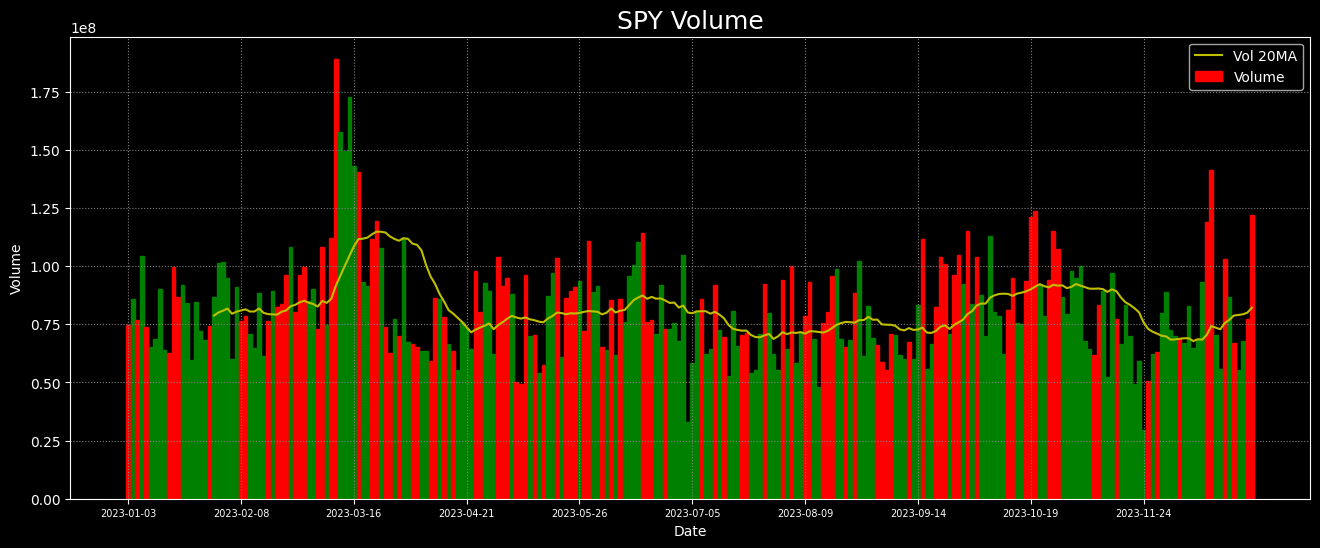

In [11]:
def plot_volume(
        data:   pd.DataFrame,
        ticker: str,
        start:  str | None = None,
        end:    str | None = None,
        *,
        style:     str                 = 'dark_background',
        figsize:   tuple[float] | None = None,
        bar_color: str | None          = None,
        ma:        int | bool          = True,
        ma_color:  str                 = 'y',
        legendloc: str | None          = None
) -> None:
    """
        Plots volume and a moving average of a specific ticker.
        #### return None

        Params
        ---
        - data: pd.DataFrame
            Takes volume data with no modifications,
            Column name must be 'Volume'
        - ticker: str
            The ticker to plot.
        - start: str | None=None
            The start date formatted as 'YYYY-MM-DD' or 'YYYY-MM-DD hh:mm', inclusive.
        - end: str | None=None
            The end date formatted as 'YYYY-MM-DD' or 'YYYY-MM-DD hh:mm', inclusive.
        - style: str='dark_background'
            Style of the plot, check available styles with `plt.style.available`
        - figsize: tuple[int] | None=None
            Width and height of the plot,
            if None, defaults to (16, 6)
        - bar_color: str=None
            Color of the volume bars,
            if None, defaults to color based on the movement of each interval.
        - ma: int | bool=True
            Length of the volume moving average, only one.
            If False, do not show moving average,
            if True, defaults to a 20 moving average.
        - ma_color: str='orange'
            Color of the volume moving average line.
        - legendloc: str | None=None
            Location of the legend,
            if None, defaults to the best location.

        Example use
        ---
        `aa.plot_volume(data, 'SPY', bar_color='w', ma=50)`
    """

    # Prepare data to be plotted
    date_format = '%Y-%m-%d'
    if data.index.name == 'Datetime':
        date_format = '%Y-%m-%d %H:%M'
    data_to_plot = data.loc[start:end][ticker]
    data_to_plot.index = data_to_plot.index.strftime(date_format)
    data_ma = data[ticker]
    data_ma.index = data_ma.index.strftime(date_format)

    # Plot
    with plt.style.context(style):
        if figsize is None:
            figsize = (16, 6)

        plt.figure(figsize=figsize)
        plt.title(f'{ticker} Volume', size=18)

        # Color vol bars based on if the price went up or down in that interval
        if bar_color is None:
            period_ret = (data_ma['Close'] - data_ma['Open']) \
                         / data_ma['Open'] * 100
            colors = ['r' if ret < 0 else 'g' for ret in period_ret]
            bar_color = pd.Series(colors,
                                index=period_ret.index
                                ).loc[start:end]

        # Plot volume bars
        plt.bar(x=data_to_plot.index,
                height=data_to_plot['Volume'],
                color=bar_color,
                edgecolor=bar_color,
                label='Volume')

        # Volume Moving Average
        if ma is True:
            ma = 20
        if ma is not False:
            plt.plot(data_ma['Volume'].rolling(ma).mean().loc[start:end],
                     color=ma_color,
                     label=f'Vol {ma}MA')

        plt.grid(which='major', color='grey', linestyle=':')
        plt.xticks(np.arange(len(data_to_plot),
                             step=max(len(data_to_plot) // 10, 1)),
                   size=7)
        plt.legend(loc=legendloc)
        plt.xlabel('Date')
        plt.ylabel('Volume')

        plt.show()

plot_volume(data, 'SPY')

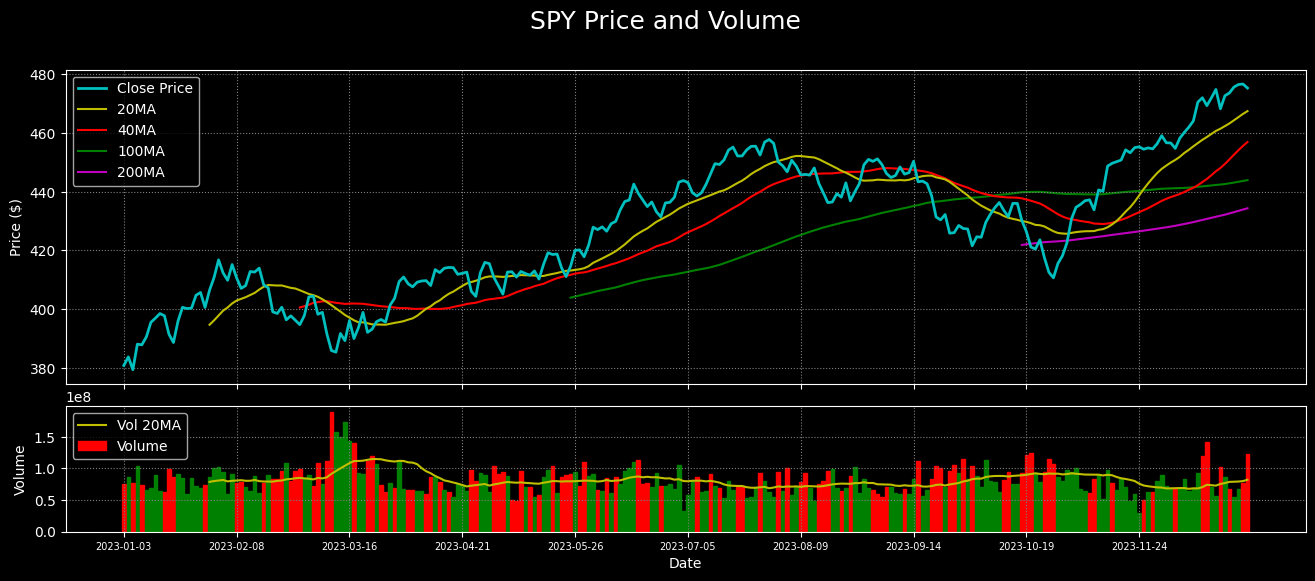

In [12]:
def plot_price_vol(
        data:   pd.DataFrame,
        ticker: str,
        start:  str | None = None,
        end:    str | None = None,
        *,
        style:           str                 = 'dark_background',
        figsize:         tuple[float] | None = None,
        use_price:       str                 = 'Close',
        price_color:     str                 = 'c',
        price_mas:       list[int] | bool    = True,
        price_mas_color: list[str] | None    = None,
        vol_bar_color:   str | None          = None,
        volume_ma:       int | bool          = True,
        vol_ma_color:    str                 = 'y',
        legendloc:       str | None          = None
) -> None:
    """
        Plots the price, volume and moving averages of a specific ticker.
        #### return None

        Params
        ---
        - data: pd.DataFrame
            Takes price and volume data with no modifications.
        - ticker: str
            The ticker to plot.
        - start: str | None=None
            The start date formatted as 'YYYY-MM-DD' or 'YYYY-MM-DD hh:mm', inclusive.
        - end: str | None=None
            The end date formatted as 'YYYY-MM-DD' or 'YYYY-MM-DD hh:mm', inclusive.
        - style: str='dark_background'
            Style of the plot, check available styles with `plt.style.available`
        - figsize: tuple[int] | None=None
            Width and height of the plot,
            if None, defaults to (16, 6)
        - use_price: str='Close'
            The price column to be used for plotting the price.
        - price_color: str='cyan'
            Color of the price line.
        - price_mas: list[str] | None=None
            Length of price moving averages, as many as wished,
            if None, defaults to 20, 40, 100 and 200
        - price_mas_color: list[str] | None=None
            Color of each of the price moving averages in order,
            if None, defaults to a palette.
        - vol_bar_color: str=None
            Color of the volume bars,
            if None, defaults to color based on the movement of each interval.
        - volume_ma: int | bool=True
            Length of the volume moving average, only one.
            If False, do not show moving average,
            if True, defaults to a 20 moving average.
        - vol_ma_color: str='orange'
            Color of the volume moving average line.
        - legendloc: str | None=None
            Location of the legend,
            if None, defaults to the best location.

        Example use
        ---
        `aa.plot_price_vol(data, 'SPY', price_color='w', price_mas=[20, 50, 100, 150])`
    """

    # Prepare data to be plotted
    date_format = '%Y-%m-%d'
    if data.index.name == 'Datetime':
        date_format = '%Y-%m-%d %H:%M'
    data_to_plot = data.loc[start:end][ticker]
    data_to_plot.index = data_to_plot.index.strftime(date_format)
    data_ma = data[ticker]
    data_ma.index = data_ma.index.strftime(date_format)

    # Plot
    with plt.style.context(style):
        if figsize is None:
            figsize = (16, 6)

        fig, axs = plt.subplots(2,
                                figsize=(figsize),
                                height_ratios=(5, 2),
                                sharex=True)
        plt.suptitle(f'{ticker} Price and Volume', size=18)
        plt.subplots_adjust(hspace=0.1)

        # Price
        axs[0].plot(data_to_plot[use_price],
                    color=price_color,
                    linewidth=2,
                    zorder=20,
                    label=f'{use_price} Price')

        # Price Moving Averages
        if price_mas is not False:
            if price_mas is True:
                price_mas = [20, 40, 100, 200]
            if price_mas_color is None:
                 price_mas_color = ['y', 'r', 'g', 'm']

            for m, c, z in zip(price_mas,
                               range(len(price_mas_color)+100),
                               range(len(price_mas)-1, -1, -1)):
                axs[0].plot(data_ma[use_price].rolling(m).mean().loc[start:end],
                            color=price_mas_color[c % len(price_mas_color)],
                            zorder=z,
                            label=f'{m}MA')

        axs[0].grid(which='major', color='grey', linestyle=':')
        axs[0].set_ylabel('Price ($)')
        axs[0].legend(loc=legendloc)

        # Volume
        # Color vol bars based on if the price went up or down in that interval
        if vol_bar_color is None:
            period_ret = (data_ma['Close'] - data_ma['Open']) \
                            / data_ma['Open'] * 100
            colors = ['r' if ret < 0 else 'g' for ret in period_ret]
            vol_bar_color = pd.Series(colors,
                                index=period_ret.index
                                ).loc[start:end]

        # Plot volume bars
        axs[1].bar(x=data_to_plot.index,
                    height=data_to_plot['Volume'],
                    color=vol_bar_color,
                    edgecolor=vol_bar_color,
                    label='Volume')

        # Volume Moving Average
        if volume_ma is True:
            volume_ma = 20
        if volume_ma is not False:
            axs[1].plot(data_ma['Volume'].rolling(volume_ma).mean().loc[start:end],
                        color=vol_ma_color,
                        label=f'Vol {volume_ma}MA')

        axs[1].grid(which='major', color='grey', linestyle=':')
        axs[1].set_ylabel('Volume')
        axs[1].legend(loc=legendloc)

        plt.xticks(np.arange(len(data_to_plot),
                             step=max(len(data_to_plot) // 10, 1)),
                   size=7)
        plt.xlabel('Date')

        plt.show()

plot_price_vol(data, 'SPY')

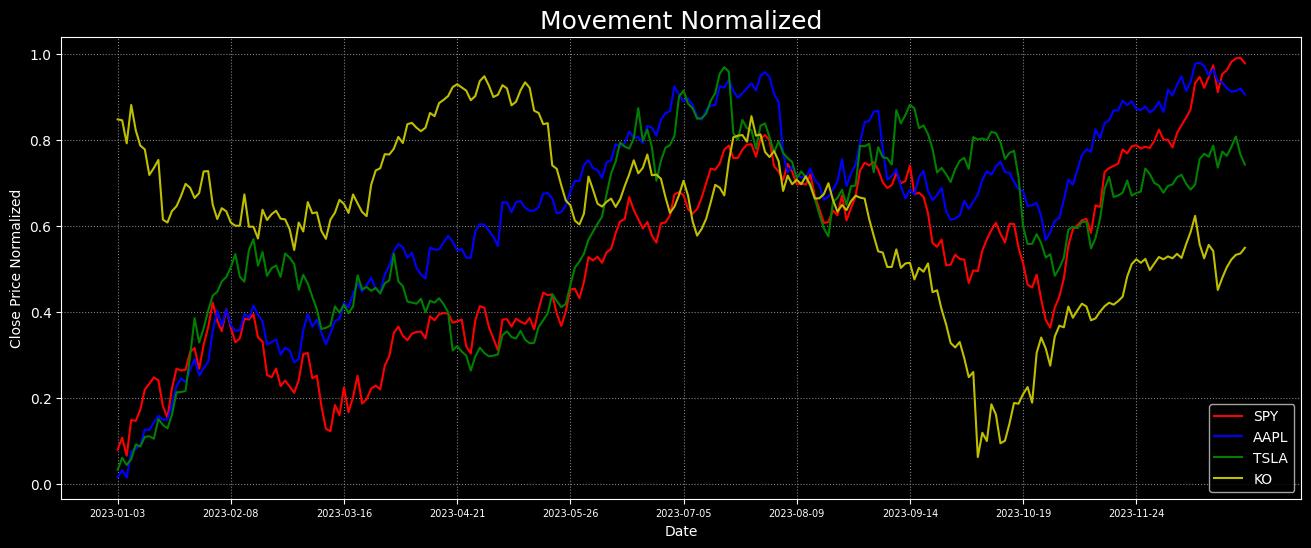

In [13]:
def plot_norm_moves(
        data_norm: pd.DataFrame,
        tickers:   list[str] | None  = None,
        start:     str | None        = None,
        end:       str | None        = None,
        *,
        style:     str               = 'dark_background',
        figsize:   tuple[int] | None = None,
        use_price: str               = 'Close_norm',
        colors:    list[str] | None  = None,
        legendloc: str | None        = None
) -> None:
    """
        Plots movement of normalized prices,
        compare movements between assets by giving more than one ticker.
        #### return None

        Params
        ---
        - data_norm: pd.DataFrame
            Takes normalized price data,
            can get it with the normalize_values() function.
        - ticker: list[str] | None=None
            The tickers to plot,
            if None, default to plot all.
        - start: str | None=None
            The start date formatted as 'YYYY-MM-DD' or 'YYYY-MM-DD hh:mm', inclusive.
        - end: str | None=None
            The end date formatted as 'YYYY-MM-DD' or 'YYYY-MM-DD hh:mm', inclusive.
        - style: str='dark_background'
            Style of the plot, check available styles with `plt.style.available`
        - figsize: tuple[int] | None=None
            Width and height of the plot,
            if None, defaults to (16, 6)
        - use_price: str='Close_norm'
            The normalized price column to be used for plotting the price.
        - colors: list[str] | None=None
            List with the color of each line in order,
            if None, defaults to a palette.
        - legendloc: str | None=None
            Location of the legend,
            if None, defaults to the best location.

        Example use
        ---
        `aa.plot_norm_moves(data_norm, ['SPY', 'AAPL'], colors=['w', 'r'])`
    """

    # Prepare data to be plotted
    if tickers is None:
        tickers = data_norm.columns.get_level_values(0).unique()
    date_format = '%Y-%m-%d'
    if data_norm.index.name == 'Datetime':
        date_format = '%Y-%m-%d %H:%M'
    data_to_plot = data_norm.loc[start:end][tickers]
    data_to_plot.index = data_to_plot.index.strftime(date_format)

    if colors is None:
        colors = ['r', 'b', 'g', 'y', 'm', 'c']
    if figsize is None:
        figsize = (16, 6)

    # Plot
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        plt.title('Movement Normalized', size=18)

        for i, tk in enumerate(tickers):
            plt.plot(data_to_plot[tk, use_price],
                     color=colors[i % len(colors)],
                     alpha=1,
                     label=tk)

        plt.grid(which='major', color='grey', linestyle=':')
        plt.xticks(np.arange(len(data_to_plot),
                             step=max(len(data_to_plot) // 10, 1)),
                   size=7)
        plt.legend(loc=legendloc)
        plt.xlabel('Date')
        plt.ylabel(f'{use_price.split("_")[0]} Price Normalized')
        plt.show()

plot_norm_moves(data_norm)

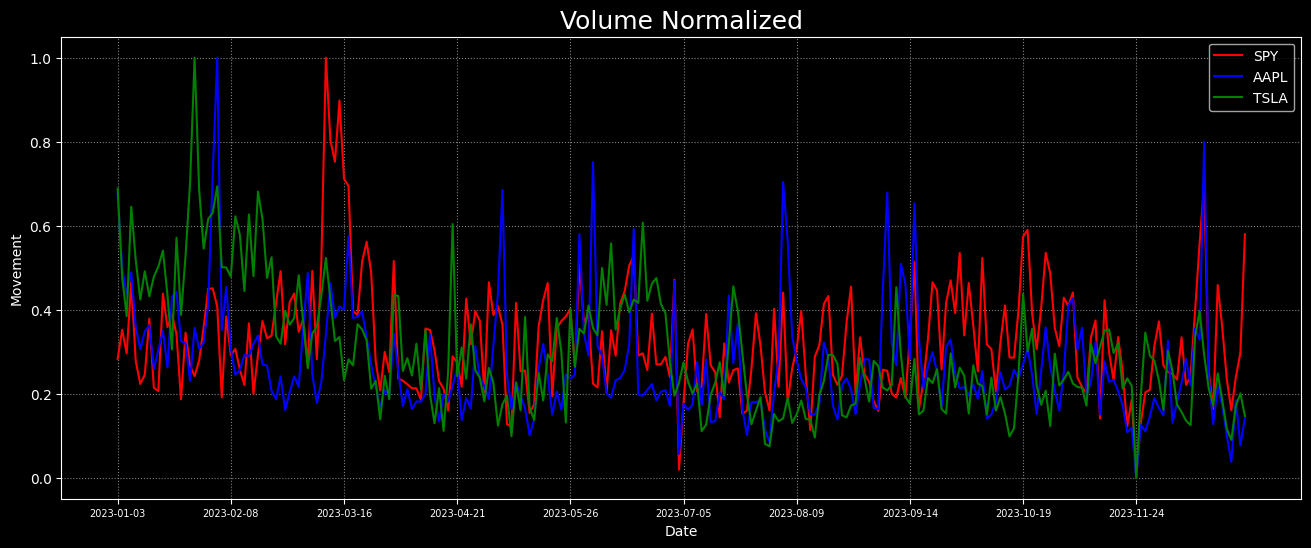

In [14]:
def plot_norm_vol(
    data_norm: pd.DataFrame,
    tickers:   list[str] | None  = None,
    start:     str | None        = None,
    end:       str | None        = None,
    *,
    style:     str               = 'dark_background',
    figsize:   tuple[int] | None = None,
    colors:    list[str] | None  = None,
    legendloc: str | None        = None
) -> None:
    """
        Plots movement of the normalized volume,
        compare movements between assets by giving more than one ticker.
        #### return None

        Params
        ---
        - data_norm: pd.DataFrame
            Takes normalized volume data,
            can get it with the normalize_values() function.
            Column name must be 'Volume_norm'
        - tickers: list[str] | None= None
            The tickers to be plotted, maximum of three,
            if None, defaults to plot the first three tickers.
        - start: str | None=None
            The start date formatted as 'YYYY-MM-DD' or 'YYYY-MM-DD hh:mm', inclusive.
        - end: str | None=None
            The end date formatted as 'YYYY-MM-DD' or 'YYYY-MM-DD hh:mm', inclusive.
        - style: str='dark_background'
            Style of the plot, check available styles with `plt.style.available`
        - figsize: tuple[int] | None=None
            Width and height of the plot,
            if None, defaults to (16, 6)
        - colors: list[str] | None=None
            List with the color of each line in order,
            if None, defaults to a palette.
        - legendloc: str | None=None
            Location of the legend,
            if None, defaults to the best location.

        Example use
        ---
        `aa.plot_norm_vol(data_norm, ['SPY', 'AAPL'], colors=['w', 'r'])`
    """

    # Prepare data to be plotted
    if tickers is None:
        tickers = data_norm.columns.get_level_values(0).unique()[:3]
    date_format = '%Y-%m-%d'
    if data_norm.index.name == 'Datetime':
        date_format = '%Y-%m-%d %H:%M'
    data_to_plot = data_norm.loc[start:end][tickers]
    data_to_plot.index = data_to_plot.index.strftime(date_format)

    if colors is None:
        colors = ['r', 'b', 'g']
    if figsize is None:
        figsize = (16, 6)

    # Plot
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        plt.title('Volume Normalized', size=18)

        for ticker, color in zip(tickers, colors):
            plt.plot(data_to_plot[ticker, 'Volume_norm'],
                     label=ticker,
                     color=color)

        plt.grid(which='major', color='grey', linestyle=':')
        plt.xticks(np.arange(len(data_to_plot),
                             step=max(len(data_to_plot) // 10, 1)),
                   size=7)
        plt.legend(loc=legendloc)
        plt.xlabel('Date')
        plt.ylabel('Movement')
        plt.show()

plot_norm_vol(data_norm)

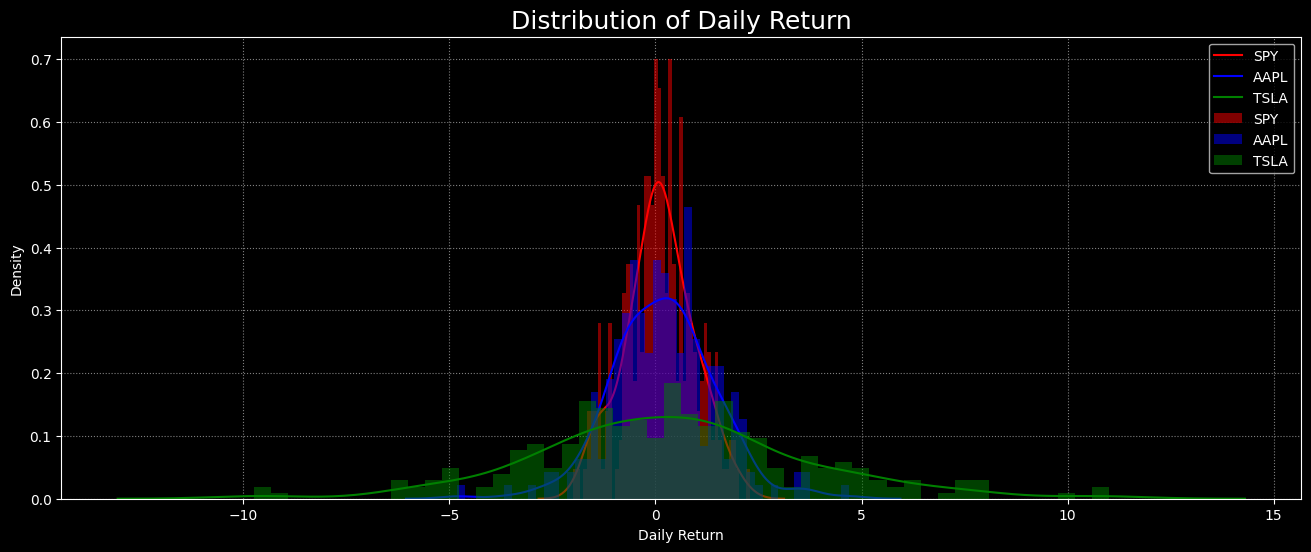

In [15]:
def plot_dist_ret(
        data_ret:  pd.DataFrame,
        tickers:   list[str] | None  = None,
        start:     str | None        = None,
        end:       str | None        = None,
        *,
        style:     str               = 'dark_background',
        figsize:   tuple[int] | None = None,
        use_ret:   str               = 'Daily',
        colors:    list[str] | None  = None,
        hist:      bool              = True,
        kde:       bool              = True,
        legendloc: str | None        = None
) -> None:
    """
        Plots the distribution of the returns of the given period.
        #### return None

        Params
        ---
        - data_ret: pd.DataFrame
            Takes returns data,
            can get it with the pct_returns() function.
        - tickers: list[str] | None= None
            The tickers to be plotted, maximum of three,
            if None, defaults to plot the first three tickers.
        - start: str | None=None
            The start date formatted as 'YYYY-MM-DD', inclusive.
        - end: str | None=None
            The end date formatted as 'YYYY-MM-DD', inclusive.
        - style: str='dark_background'
            Style of the plot, check available styles with `plt.style.available`
        - figsize: tuple[int] | None=None
            Width and height of the plot,
            if None, defaults to (16, 6)
        - use_ret: str='Daily'
            The return column to be used for plotting the price.
        - colors: list[str] | None=None
            List with the color of each element in order,
            if None, defaults to a palette.
        - hist: bool=True
            If to show histogram plot.
        - kde: bool=True
            If to show kernel density estimate plot.
        - legendloc: str | None=None
            Location of the legend,
            if None, defaults to the best location.

        Example use
        ---
        `aa.plot_dist_ret(data_ret, ['SPY', 'AAPL'], colors=['w', 'r'], use_ret='Intraday')`
    """

    if tickers is None:
        tickers = data_ret.columns.get_level_values(0).unique()[:3]
    else:
        tickers = tickers[:3]
    data_to_plot = data_ret.loc[start:end][tickers]

    if colors is None:
        colors = ['r', 'b', 'g']
    if figsize is None:
        figsize = (16, 6)

    # Plot
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        plt.title(f'Distribution of {use_ret} Return', size=18)

        for ticker, color in zip(tickers, colors):
            if hist:
                sns.histplot(data_to_plot[ticker,  use_ret],
                             bins=50, color=color,
                             edgecolor=None,
                             alpha=0.5,
                             kde=False,
                             stat="density",
                             zorder=2,
                             label=ticker)

            if kde:
                sns.kdeplot(data_to_plot[ticker,  use_ret],
                            color=color,
                            zorder=2,
                            label=ticker)

        plt.grid(which='major', color='grey', zorder=0, linestyle=':')
        plt.legend(loc=legendloc)
        plt.xlabel(f'{use_ret} Return')
        plt.ylabel(f'Density')
        plt.show()

plot_dist_ret(data_ret)

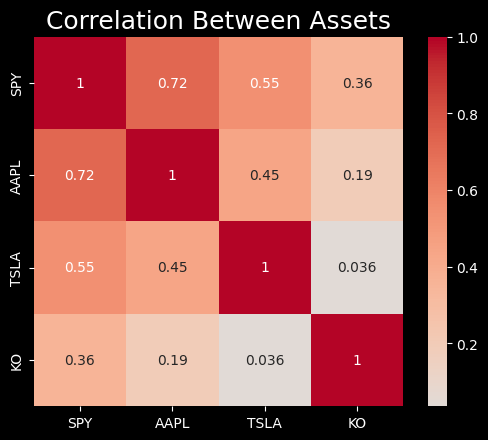

,SPY,AAPL,TSLA,KO
SPY,1.000000,0.721111,0.546188,0.357512
AAPL,0.721111,1.000000,0.445561,0.191303
TSLA,0.546188,0.445561,1.000000,0.036287
KO,0.357512,0.191303,0.036287,1.000000


In [16]:
def correlations(
        data: pd.DataFrame,
        tickers:   list[str] | None = None,
        start:     str | None       = None,
        end:       str | None       = None,
        *,
        use_price: str  = 'Close',
        plot:      bool = True,
        style:     str  = 'dark_background'
) -> pd.DataFrame:
    """
        Calculates the correlation between assets and plots a heatmap.
        #### return pd.DataFrame

        Params
        ---
        - data: pd.DataFrame
            Takes price data.
        - ticker: list[str] | None=None
            The tickers to use,
            if None, default to use all.
        - start: str | None=None
            The start date formatted as 'YYYY-MM-DD', inclusive.
        - end: str | None=None
            The end date formatted as 'YYYY-MM-DD', inclusive.
        - use_price: str='Close_norm'
            The normalized price column to be used for plotting the price.
        - plot: bool=True
            If to show the heatmap of the correleations.
        - style: str='dark_background'
            Style of the plot, check available styles with `plt.style.available`

        Example use
        ---
        `corr_matrix = aa.correlations(data)`
    """

    data_to_use = data.loc[:, pd.IndexSlice[:, use_price]]
    if tickers is None:
        tickers = data_to_use.columns
    data_to_use = data_to_use.loc[start:end][tickers]

    returns =  data_to_use.pct_change()

    # Correlation matrix
    corr_matrix = returns.corr()
    corr_matrix.columns = corr_matrix.columns.get_level_values(0)
    corr_matrix.columns.name = None
    corr_matrix.index = corr_matrix.index.get_level_values(0)
    corr_matrix.index.name = None

    # Plot
    if plot:
        with plt.style.context(style):
            plt.title('Correlation Between Assets', size=18)
            sns.heatmap(corr_matrix,
                        cmap='coolwarm',
                        center=0,
                        annot=True,
                        square=True)
            plt.show()

    return corr_matrix

corr_matrix = correlations(data)
corr_matrix

# Calculations

In [17]:
def sharpe_ratio(
        data:   pd.DataFrame,
        ticker: str,
        start:  str | None = None,
        end:    str | None = None,
        *,
        use_price:      str   = 'Close',
        risk_free_rate: float = 0.05
) -> float:
    """
        Docs
    """

    data_to_use = data.loc[start:end][ticker][use_price]

    returns = data_to_use.pct_change()
    portfolio_return = returns.mean()
    portfolio_volatility = returns.std()

    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    return sharpe_ratio

sharpe_r = sharpe_ratio(data, 'SPY')
sharpe_r

-5.899477442859234

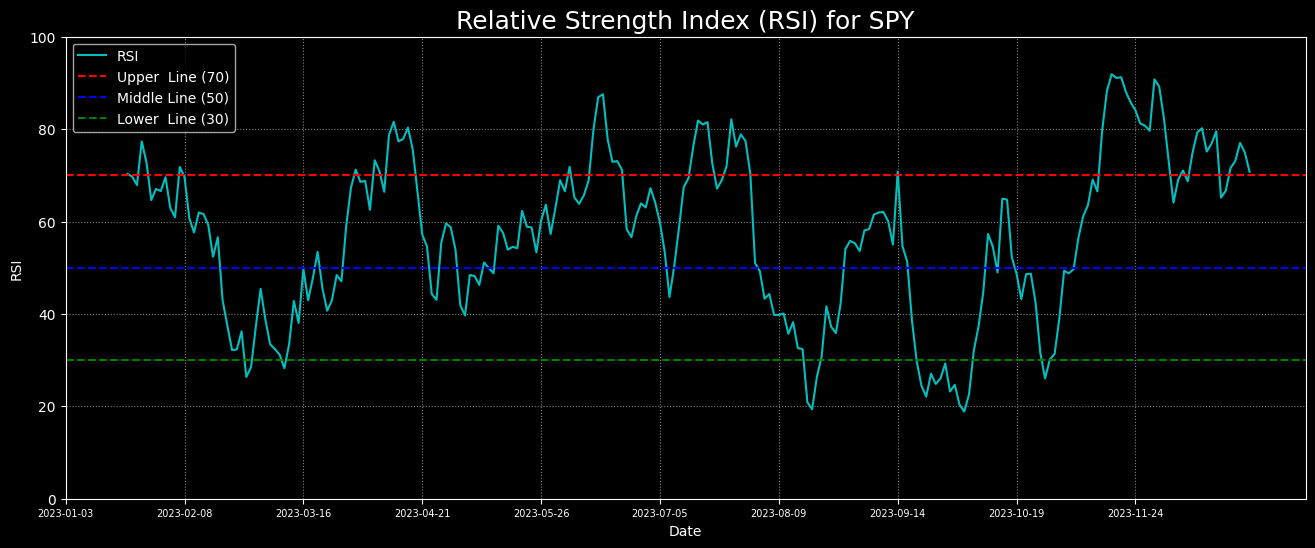

Ticker             SPY                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2023-01-03  384.369995  386.429993  377.829987  380.820007  373.956818   
2023-01-04  383.179993  385.880005  380.000000  383.760010  376.843842   
2023-01-05  381.720001  381.839996  378.760010  379.380005  372.542755   
2023-01-06  382.609985  389.250000  379.410004  388.079987  381.085938   
2023-01-09  390.369995  393.700012  387.670013  387.859985  380.869934   
...                ...         ...         ...         ...         ...   
2023-12-22  473.859985  475.380005  471.700012  473.649994  472.182892   
2023-12-26  474.070007  476.579987  473.989990  475.649994  474.176697   
2023-12-27  475.440002  476.660004  474.890015  476.510010  475.034058   
2023-12-28  476.880005  477.549988  476.260010  476.690002  475.213501   
2023-12-29  476.489990  477.029999  473.299988  475.309998  473.837769   

Ticker                       AAPL                                      ...  \
Price          Volume        Open        High         Low       Close  ...   
Date                                                                   ...   
2023-01-03   74850700  130.279999  130.899994  124.169998  125.070000  ...   
2023-01-04   85934100  126.889999  128.660004  125.080002  126.360001  ...   
2023-01-05   76970500  127.129997  127.769997  124.760002  125.019997  ...   
2023-01-06  104189600  126.010002  130.289993  124.889999  129.619995  ...   
2023-01-09   73978100  130.470001  133.410004  129.889999  130.149994  ...   
...               ...         ...         ...         ...         ...  ...   
2023-12-22   67126600  195.179993  195.410004  192.970001  193.600006  ...   
2023-12-26   55387000  193.610001  193.889999  192.830002  193.050003  ...   
2023-12-27   68000300  192.490005  193.500000  191.089996  193.149994  ...   
2023-12-28   77158100  194.139999  194.660004  193.169998  193.580002  ...   
2023-12-29  122234100  193.899994  194.399994  191.729996  192.529999  ...   

Ticker            TSLA                                KO             \
Price            Close   Adj Close     Volume       Open       High   
Date                                                                  
2023-01-03  108.099998  108.099998  231402800  63.560001  63.560001   
2023-01-04  113.639999  113.639999  180389000  63.150002  63.330002   
2023-01-05  110.339996  110.339996  157986300  62.599998  62.799999   
2023-01-06  113.059998  113.059998  220911100  62.910000  63.669998   
2023-01-09  119.769997  119.769997  190284000  63.299999  63.720001   
...                ...         ...        ...        ...        ...   
2023-12-22  252.539993  252.539993   93249800  58.119999  58.459999   
2023-12-26  256.609985  256.609985   86892400  58.060001  58.709999   
2023-12-27  261.440002  261.440002  106494400  58.639999  58.770000   
2023-12-28  253.179993  253.179993  113619900  58.650002  58.869999   
2023-12-29  248.479996  248.479996  100615300  58.740002  58.980000   

Ticker                                                Calculations  
Price             Low      Close  Adj Close    Volume          RSI  
Date                                                                
2023-01-03  62.180000  62.950001  60.540474  12180500          NaN  
2023-01-04  62.509998  62.919998  60.511616  13387900          NaN  
2023-01-05  62.080002  62.200001  59.819176   9814700          NaN  
2023-01-06  62.580002  63.400002  60.973248   9990000          NaN  
2023-01-09  62.580002  62.610001  60.213482   9442600          NaN  
...               ...        ...        ...       ...          ...  
2023-12-22  58.020000  58.320000  57.857216   9028500    71.555660  
2023-12-26  58.060001  58.560001  58.095314   6422500    73.090894  
2023-12-27  58.400002  58.709999  58.244122   8560100    77.005202  
2023-12-28  58.529999  58.750000  58.283806   8

In [18]:
def calc_rsi(
        data:   pd.DataFrame,
        ticker: str,
        start:  str | None = None,
        end:    str | None = None,
        *,
        use_price: str  = 'Close',
        window:    int  = 14,
        add_col:   bool = True,
        plot:      bool = True,
        style:     str  = 'dark_background',
        figsize:   tuple[int] | None = None,
        color:     str  = 'c',
        up_line:   int  = 70,
        lo_line:   int  = 30
) -> pd.DataFrame:
    """
        Docs
    """

    data_to_use = data.loc[start:end][ticker][use_price]

    # Calculate RSI
    delta = data_to_use.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Prepare data to be returned
    if add_col:
        df = data.copy()
        df[('Calculations', 'RSI')] = rsi
    else:
        df = rsi

    if plot:
        # Prepate data to plot
        data_to_plot = rsi
        date_format = '%Y-%m-%d'
        if data_to_plot.index.name == 'Datetime':
            date_format = '%Y-%m-%d %H:%M'
        data_to_plot.index = data_to_plot.index.strftime(date_format)

        if figsize is None:
            figsize = (16, 6)

        # Plot
        with plt.style.context(style):
            plt.figure(figsize=figsize)
            plt.title(f'Relative Strength Index (RSI) for {ticker}', size=18)

            plt.plot(data_to_plot, color=color, label='RSI')
            plt.axhline(up_line, color='r', linestyle='--', label=f'Upper  Line ({up_line})')
            plt.axhline(50     , color='b', linestyle='--', label='Middle Line (50)')
            plt.axhline(lo_line, color='g', linestyle='--', label=f'Lower  Line ({lo_line})')

            plt.grid(which='major', color='grey', zorder=0, linestyle=':')
            plt.xticks(np.arange(len(data_to_plot),
                                step=max(len(data_to_plot) // 10, 1)),
                       size=7)
            plt.ylim(0, 100)
            plt.legend()
            plt.xlabel('Date')
            plt.ylabel('RSI')
            plt.show()

    return df

data_with_calcs = calc_rsi(data, 'SPY')
data_with_calcs

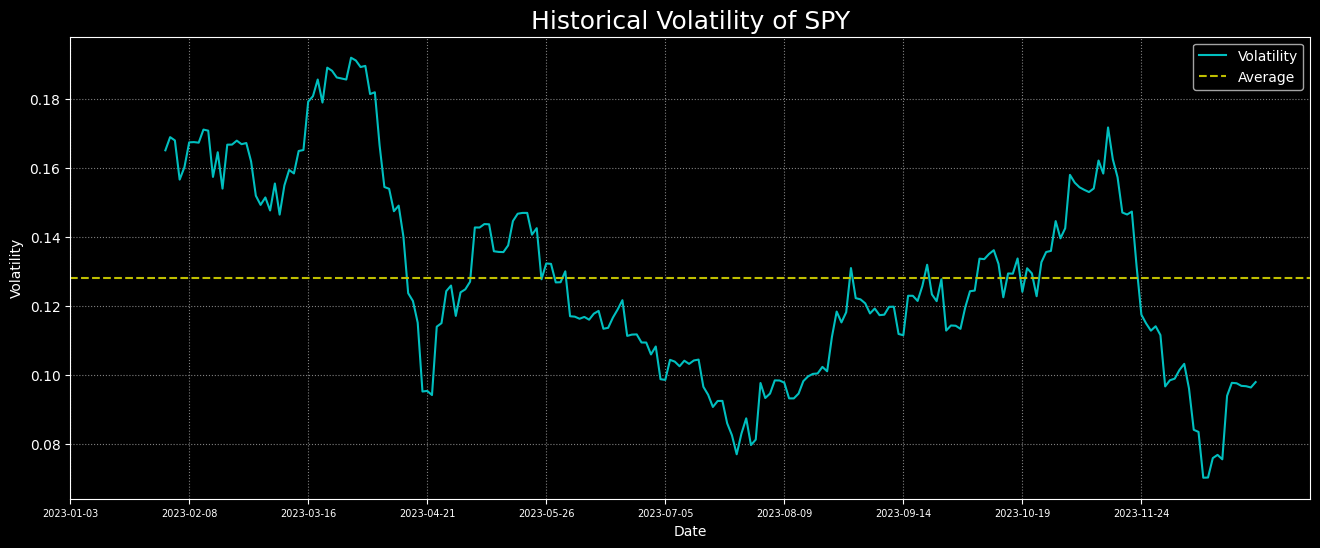

Ticker             SPY                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2023-01-03  384.369995  386.429993  377.829987  380.820007  373.956818   
2023-01-04  383.179993  385.880005  380.000000  383.760010  376.843842   
2023-01-05  381.720001  381.839996  378.760010  379.380005  372.542755   
2023-01-06  382.609985  389.250000  379.410004  388.079987  381.085938   
2023-01-09  390.369995  393.700012  387.670013  387.859985  380.869934   
...                ...         ...         ...         ...         ...   
2023-12-22  473.859985  475.380005  471.700012  473.649994  472.182892   
2023-12-26  474.070007  476.579987  473.989990  475.649994  474.176697   
2023-12-27  475.440002  476.660004  474.890015  476.510010  475.034058   
2023-12-28  476.880005  477.549988  476.260010  476.690002  475.213501   
2023-12-29  476.489990  477.029999  473.299988  475.309998  473.837769   

Ticker                       AAPL                                      ...  \
Price          Volume        Open        High         Low       Close  ...   
Date                                                                   ...   
2023-01-03   74850700  130.279999  130.899994  124.169998  125.070000  ...   
2023-01-04   85934100  126.889999  128.660004  125.080002  126.360001  ...   
2023-01-05   76970500  127.129997  127.769997  124.760002  125.019997  ...   
2023-01-06  104189600  126.010002  130.289993  124.889999  129.619995  ...   
2023-01-09   73978100  130.470001  133.410004  129.889999  130.149994  ...   
...               ...         ...         ...         ...         ...  ...   
2023-12-22   67126600  195.179993  195.410004  192.970001  193.600006  ...   
2023-12-26   55387000  193.610001  193.889999  192.830002  193.050003  ...   
2023-12-27   68000300  192.490005  193.500000  191.089996  193.149994  ...   
2023-12-28   77158100  194.139999  194.660004  193.169998  193.580002  ...   
2023-12-29  122234100  193.899994  194.399994  191.729996  192.529999  ...   

Ticker           TSLA         KO                                              \
Price          Volume       Open       High        Low      Close  Adj Close   
Date                                                                           
2023-01-03  231402800  63.560001  63.560001  62.180000  62.950001  60.540474   
2023-01-04  180389000  63.150002  63.330002  62.509998  62.919998  60.511616   
2023-01-05  157986300  62.599998  62.799999  62.080002  62.200001  59.819176   
2023-01-06  220911100  62.910000  63.669998  62.580002  63.400002  60.973248   
2023-01-09  190284000  63.299999  63.720001  62.580002  62.610001  60.213482   
...               ...        ...        ...        ...        ...        ...   
2023-12-22   93249800  58.119999  58.459999  58.020000  58.320000  57.857216   
2023-12-26   86892400  58.060001  58.709999  58.060001  58.560001  58.095314   
2023-12-27  106494400  58.639999  58.770000  58.400002  58.709999  58.244122   
2023-12-28  113619900  58.650002  58.869999  58.529999  58.750000  58.283806   
2023-12-29  100615300  58.740002  58.980000  58.630001  58.930000  58.462376   

Ticker               Calculations                        
Price         Volume          RSI Log Return Volatility  
Date                                                     
2023-01-03  12180500          NaN        NaN        NaN  
2023-01-04  13387900          NaN   0.007691        NaN  
2023-01-05   9814700          NaN  -0.011479        NaN  
2023-01-06   9990000          NaN   0.022673        NaN  
2023-01-09   9442600          NaN  -0.000567        NaN  
...              ...          ...        ...        ...  
2023-12-22   9028500    71.555660   0.002008   0.097671  
2023-12-26   6422500    73.090894   0.004214   0.096916  
2023-12-27   8560100    77.005202   0.001806   0.096816  
2023-12-28   8400100    74.959419   0.000378   0.0964

In [19]:
def calc_historical_volatility(
        data:   pd.DataFrame,
        ticker: str,
        start:  str | None = None,
        end:    str | None = None,
        *,
        use_price: str  = 'Close',
        window:    int  = 20,
        add_col:   bool = True,
        plot:      bool = True,
        style:     str  = 'dark_background',
        figsize:   tuple[int] | None = None,
        color:     str  = 'c'
) -> pd.DataFrame:
    """
        Docs
    """

    data_to_use = data.loc[start:end][ticker][use_price]

    log_return = np.log(data_to_use / data_to_use.shift(1))
    volatility = log_return.rolling(window).std() * np.sqrt(252)

    # Prepare data to be returned
    if add_col:
        df = data.copy()
        df[('Calculations', 'Log Return')] = log_return
        df[('Calculations', 'Volatility')] = volatility
    else:
        df = pd.DataFrame([log_return, volatility],
                          index=['Log Return', 'Volatility'])
        df = df.T

    if plot:
        # Prepate data to plot
        data_to_plot = volatility
        date_format = '%Y-%m-%d'
        if data_to_plot.index.name == 'Datetime':
            date_format = '%Y-%m-%d %H:%M'
        data_to_plot.index = data_to_plot.index.strftime(date_format)

        if figsize is None:
            figsize = (16, 6)

        # Plot
        with plt.style.context(style):
            plt.figure(figsize=figsize)
            plt.title(f'Historical Volatility of {ticker}', size=18)

            plt.plot(data_to_plot, color=color, label='Volatility')
            plt.axhline(data_to_plot.mean(), color='y', linestyle='--', label='Average')

            plt.grid(which='major', color='grey', zorder=0, linestyle=':')
            plt.xticks(np.arange(len(data_to_plot),
                                step=max(len(data_to_plot) // 10, 1)),
                       size=7)
            plt.legend()
            plt.xlabel('Date')
            plt.ylabel('Volatility')
            plt.show()

    return df

data_with_calcs = calc_historical_volatility(data_with_calcs, 'SPY')
data_with_calcs

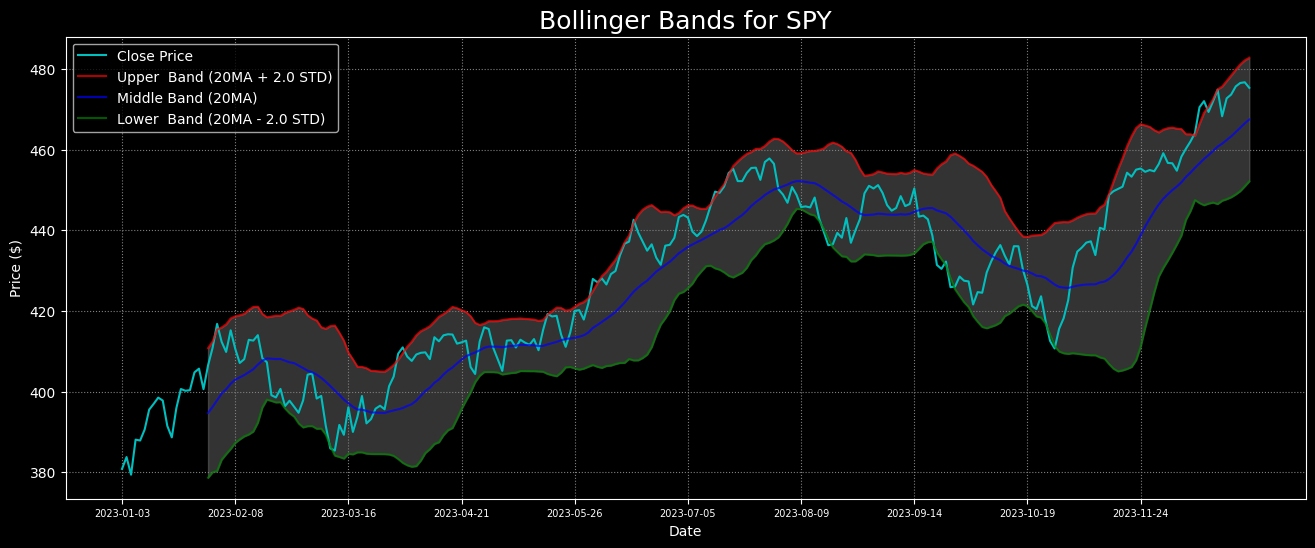

Ticker             SPY                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2023-01-03  384.369995  386.429993  377.829987  380.820007  373.956818   
2023-01-04  383.179993  385.880005  380.000000  383.760010  376.843842   
2023-01-05  381.720001  381.839996  378.760010  379.380005  372.542755   
2023-01-06  382.609985  389.250000  379.410004  388.079987  381.085938   
2023-01-09  390.369995  393.700012  387.670013  387.859985  380.869934   
...                ...         ...         ...         ...         ...   
2023-12-22  473.859985  475.380005  471.700012  473.649994  472.182892   
2023-12-26  474.070007  476.579987  473.989990  475.649994  474.176697   
2023-12-27  475.440002  476.660004  474.890015  476.510010  475.034058   
2023-12-28  476.880005  477.549988  476.260010  476.690002  475.213501   
2023-12-29  476.489990  477.029999  473.299988  475.309998  473.837769   

Ticker                       AAPL                                      ...  \
Price          Volume        Open        High         Low       Close  ...   
Date                                                                   ...   
2023-01-03   74850700  130.279999  130.899994  124.169998  125.070000  ...   
2023-01-04   85934100  126.889999  128.660004  125.080002  126.360001  ...   
2023-01-05   76970500  127.129997  127.769997  124.760002  125.019997  ...   
2023-01-06  104189600  126.010002  130.289993  124.889999  129.619995  ...   
2023-01-09   73978100  130.470001  133.410004  129.889999  130.149994  ...   
...               ...         ...         ...         ...         ...  ...   
2023-12-22   67126600  195.179993  195.410004  192.970001  193.600006  ...   
2023-12-26   55387000  193.610001  193.889999  192.830002  193.050003  ...   
2023-12-27   68000300  192.490005  193.500000  191.089996  193.149994  ...   
2023-12-28   77158100  194.139999  194.660004  193.169998  193.580002  ...   
2023-12-29  122234100  193.899994  194.399994  191.729996  192.529999  ...   

Ticker             KO                                 Calculations             \
Price             Low      Close  Adj Close    Volume          RSI Log Return   
Date                                                                            
2023-01-03  62.180000  62.950001  60.540474  12180500          NaN        NaN   
2023-01-04  62.509998  62.919998  60.511616  13387900          NaN   0.007691   
2023-01-05  62.080002  62.200001  59.819176   9814700          NaN  -0.011479   
2023-01-06  62.580002  63.400002  60.973248   9990000          NaN   0.022673   
2023-01-09  62.580002  62.610001  60.213482   9442600          NaN  -0.000567   
...               ...        ...        ...       ...          ...        ...   
2023-12-22  58.020000  58.320000  57.857216   9028500    71.555660   0.002008   
2023-12-26  58.060001  58.560001  58.095314   6422500    73.090894   0.004214   
2023-12-27  58.400002  58.709999  58.244122   8560100    77.005202   0.001806   
2023-12-28  58.529999  58.750000  58.283806   8400100    74.959419   0.000378   
2023-12-29  58.630001  58.930000  58.462376   9241600    70.761170  -0.002899   

Ticker                                                     
Price      Volatility  Upper Band Middle Band  Lower Band  
Date                                                       
2023-01-03        NaN         NaN         NaN         NaN  
2023-01-04        NaN         NaN         NaN         NaN  
2023-01-05        NaN         NaN         NaN         NaN  
2023-01-06        NaN         NaN         NaN         NaN  
2023-01-09        NaN         NaN         NaN         NaN  
...               ...         ...         ...         ...  
2023-12-22   0.097671  478.348117  463.267502  448.186887  
2023-12-26   0.096916  479.776882  464.326001  448.875120  
2023-12-27   0.096816  481.105129  465.405002  449.704875  
2023-12-28   0.

In [20]:
def calc_bollinger_bands(
        data:   pd.DataFrame,
        ticker: str,
        start:  str | None = None,
        end:    str | None = None,
        *,
        use_price: str   = 'Close',
        window:    int   = 20,
        num_std:   float = 2.0,
        add_col:   bool  = True,
        plot:      bool  = True,
        style:     str   = 'dark_background',
        figsize:   tuple[int] | None = None,
        color:     str   = 'c'
) -> pd.DataFrame:
    """
        Docs
    """

    data_to_use = data.loc[start:end][ticker][use_price]

    std = data_to_use.rolling(window).std()

    middle_band = data_to_use.rolling(window).mean()
    upper_band  = middle_band + (num_std * std)
    lower_band  = middle_band - (num_std * std)

    # Prepare data to be returned
    if add_col:
        df = data.copy()
        df[('Calculations', 'Upper Band')]  = upper_band
        df[('Calculations', 'Middle Band')] = middle_band
        df[('Calculations', 'Lower Band')]  = lower_band
    else:
        df = pd.DataFrame([upper_band, middle_band, lower_band],
                          index=['Upper Band', 'Middle Band', 'Lower Band'])
        df = df.T

    if plot:
        # Prepate data to plot
        data_to_plot = data_to_use
        date_format = '%Y-%m-%d'
        if data_to_plot.index.name == 'Datetime':
            date_format = '%Y-%m-%d %H:%M'
        data_to_plot.index = data_to_plot.index.strftime(date_format)

        upper_band .index = upper_band .index.strftime(date_format)
        middle_band.index = middle_band.index.strftime(date_format)
        lower_band .index = lower_band .index.strftime(date_format)

        if figsize is None:
            figsize = (16, 6)

        # Plot
        with plt.style.context(style):
            plt.figure(figsize=figsize)
            plt.title(f'Bollinger Bands for {ticker}', size=18)

            plt.plot(data_to_plot, color=color, label=f'{use_price} Price')
            plt.plot(upper_band , color='r', alpha=0.7, label=f'Upper  Band ({window}MA + {num_std} STD)')
            plt.plot(middle_band, color='b', alpha=0.7, label=f'Middle Band ({window}MA)')
            plt.plot(lower_band , color='g', alpha=0.7, label=f'Lower  Band ({window}MA - {num_std} STD)')
            plt.fill_between(data_to_plot.index, upper_band, lower_band, color='grey', alpha=0.4)

            plt.grid(which='major', color='grey', zorder=0, linestyle=':')
            plt.xticks(np.arange(len(data_to_plot),
                                step=max(len(data_to_plot) // 10, 1)),
                       size=7)
            plt.xlabel('Date')
            plt.ylabel('Price ($)')
            plt.legend()
            plt.show()

    return df

data_with_calcs = calc_bollinger_bands(data_with_calcs, 'SPY')
data_with_calcs